In [44]:
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import *
from matplotlib.lines import Line2D
import matplotlib.ticker as mticker
from utils import *
from numpy.random import randint
from scipy.optimize import curve_fit

In [45]:
# Overwrite GPClassificationModel 
class MixtureNormalPrior(gpytorch.priors.Prior):
    def __init__(self, mean1, std1, mean2, std2, weight1):
        super().__init__()
        self.mean1 = mean1
        self.std1 = std1
        self.mean2 = mean2
        self.std2 = std2
        self.weight1 = weight1
    def log_prob(self, x):
        prob1 = self.weight1 * torch.distributions.Normal(self.mean1, self.std1).log_prob(x)
        prob2 = (1 - self.weight1) * torch.distributions.Normal(self.mean2, self.std2).log_prob(x)
        return torch.logsumexp(torch.stack([prob1, prob2]), dim=0)


class GPClassificationModel(gpytorch.models.ApproximateGP):
    """
    A class that represents a Gaussian process classification model with a constant mean and a kernel consisting of a linear kernel and a RBF kernel.
    """
    def __init__(self, train_x, mean_module, min_lengthscale=None):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, train_x, variational_distribution, learn_inducing_locations=False
        )
        super(GPClassificationModel, self).__init__(variational_strategy)
        self.mean_module = mean_module
        # Linear kernel with constraints and priors
        self.linear_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.LinearKernel(active_dims=[1]))
        linear_variance_constraint = gpytorch.constraints.GreaterThan(0.1)
        self.linear_kernel.base_kernel.variance_constraint = linear_variance_constraint
        self.linear_kernel.base_kernel.register_prior("variance_prior", gpytorch.priors.SmoothedBoxPrior(0.1, 10, sigma=.1), "variance") # SmoothedBoxPrior(.1, 4, sigma=.1)
        # RBF kernel with constraints and priors
        if min_lengthscale is not None:
            RBF_lengthscale_constraint = gpytorch.constraints.GreaterThan(min_lengthscale)
        else:
            RBF_lengthscale_constraint = gpytorch.constraints.GreaterThan(0.4)
        self.rbf_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(active_dims=[0], lengthscale_constraint=RBF_lengthscale_constraint))
        # self.rbf_kernel.base_kernel.register_prior("lengthscale_prior", gpytorch.priors.NormalPrior(.25, 0.015), "lengthscale") # LogNormalPrior(-1, 0.05), "lengthscale")
        mixture_prior = MixtureNormalPrior(mean1=0.5, std1=0.15, mean2=0.4, std2=0.15, weight1=0.9)
        self.rbf_kernel.base_kernel.register_prior("lengthscale_prior", mixture_prior, "lengthscale")
        # Set constraints and priors for the outputscale of rbf_kernel
        rbf_outputscale_constraint = gpytorch.constraints.GreaterThan(1)
        self.rbf_kernel.outputscale_constraint = rbf_outputscale_constraint
        self.rbf_kernel.register_prior("outputscale_prior", gpytorch.priors.SmoothedBoxPrior(10, 180, sigma=10), "outputscale") # SmoothedBoxPrior(50, 150, sigma=10)
        # Combining the kernels
        self.covar_module = self.linear_kernel + self.rbf_kernel
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred




In [46]:
class MTGPClassificationModel(gpytorch.models.ApproximateGP):
    def __init__(self, num_latents=1, num_tasks=2, min_lengthscale=None):
        inducing_points = torch.rand(num_latents, 50, 2)
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-2),
            batch_shape=torch.Size([num_latents])
        )
        variational_strategy = gpytorch.variational.LMCVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ),
            num_tasks=num_tasks,
            num_latents=num_latents,
            latent_dim=-1
        )
        super().__init__(variational_strategy)
        # Constraints for LinearKernel
        linear_variance_constraint = gpytorch.constraints.GreaterThan(0.1)
        # Constraints for RBFKernel
        if min_lengthscale is not None:
            RBF_lengthscale_constraint = gpytorch.constraints.GreaterThan(min_lengthscale)
        else:
            RBF_lengthscale_constraint = gpytorch.constraints.GreaterThan(0.4)
        rbf_outputscale_constraint = gpytorch.constraints.GreaterThan(1)
        # Mean module
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))
        # Linear kernel with constraints and priors
        self.linear_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.LinearKernel(active_dims=[1], batch_shape=torch.Size([num_latents])))
        self.linear_kernel.base_kernel.variance_constraint = linear_variance_constraint
        self.linear_kernel.base_kernel.register_prior("variance_prior", gpytorch.priors.SmoothedBoxPrior(.1, 50, sigma=.1), "variance")
        # RBF kernel with constraints and priors
        self.rbf_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(active_dims=[0], lengthscale_constraint=RBF_lengthscale_constraint, batch_shape=torch.Size([num_latents])))
        mixture_prior = MixtureNormalPrior(mean1=0.5, std1=0.15, mean2=0.4, std2=0.15, weight1=0.9)
        self.rbf_kernel.base_kernel.register_prior("lengthscale_prior", mixture_prior, "lengthscale")
        self.rbf_kernel.outputscale_constraint = rbf_outputscale_constraint
        self.rbf_kernel.register_prior("outputscale_prior", gpytorch.priors.SmoothedBoxPrior(5, 200, sigma=10), "outputscale")
        # Combining the kernels
        self.covar_module = self.linear_kernel + self.rbf_kernel
    def forward(self, Xt):
        mean_x = self.mean_module(Xt)
        covar_x = self.covar_module(Xt)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)




In [47]:
# 10 parameters of the data
DUMMY = 0 # 1, 2, 3… 10378
TILT = 1 # 1, -1
CUES = 2 # 1, 0
ECC = 3 # 0, 3, 6, 12
LOC = 4 # 1, -1
SF = 5 # 0.5, 1, 2, 4, 8, 11
CS = 6 # (0, 1], with NaN
ACC = 7 # 0, 1, NaN
TRIALIDX = 8 # 0, 1
CONDITION = 9 # 0

names = ['AB', 'AF', 'AS', 'LH', 'LS', 'MJ', 'RF', 'SC', 'SX']
sfs = [0.5, 1, 2, 4, 8, 11]
eccs = [0, 3, 6, 12]

In [48]:
# get data for two different cues with ecc=0
def process(name, cue, ecc):
    filename = name + '.dat'
    
    # load data from the individual
    allData = loadtxt(filename)
    
    # remove data with NaN
    data = pd.DataFrame(allData)
    data = data.dropna(axis='columns')

    data = data.to_numpy()
    
    data = data[:, where(data[ECC]==ecc)[0]]
    data = data[:, where(data[CUES]==cue)[0]]
    
    return data


In [49]:
def convert_double_to_color(doubles):
    colors = []
    for double in doubles:
        value = double
        red = 1.0 - value  # Higher value gives less red
        blue = value  # Higher value gives more blue
        green = 0.0  # No green component (optional)

        rgb = (red, green, blue)
        colors.append(rgb)
    return colors


In [50]:
big_x = []
big_y = []
task_indices_full = []

In [51]:
curve_idx = 0
for cue in range(CUES):
    for ecc in eccs:
        
        data = process('LS', cue, ecc)
        
        data = vstack((data[SF, :], data[CS, :], data[ACC,:])).T
        
        ## transform data data_zero ##############################################################
        Xt, yt, X, y = prepare_data(data, raw=True, neg_labels=False)

        ## rescale data ##############################################################
        minSF = min(X[:, 0])
        maxSF = max(X[:, 0])
        minCS = min(X[:, 1])
        maxCS = max(X[:, 1])

        def f(X):
            return scale_data_within_range(X, (0,1), minSF, maxSF, minCS, maxCS)

        data = transform_dataset(X, phi=f)
        y = y
        ########################################################################################
        task_indices = torch.LongTensor(torch.full((data.shape[0], ), dtype = torch.long, fill_value = curve_idx))
        if curve_idx == 0: 
            big_x = data
            big_y = y
            task_indices_full = task_indices
        else: 
            big_x = np.concatenate([big_x, data], axis = 0)
            print('---------------------'+ str(curve_idx) + '------------')
            print(big_y.shape)
            print(y.shape)
        
            big_y = np.concatenate([big_y.flatten(), y], axis = 0).reshape(-1, 1)
            task_indices_full = torch.cat((task_indices_full, task_indices), 0)
        
        curve_idx += 1
        
full_data = np.concatenate([big_x, big_y], axis = 1)

---------------------1------------
(3453,)
(3445,)
---------------------2------------
(6898, 1)
(3431,)
---------------------3------------
(10329, 1)
(3430,)
---------------------4------------
(13759, 1)
(3449,)
---------------------5------------
(17208, 1)
(3429,)
---------------------6------------
(20637, 1)
(3439,)
---------------------7------------
(24076, 1)
(3444,)


In [52]:
never_choose_zero_flag = True
if never_choose_zero_flag:
    rows_to_delete = where(full_data[:, 1] == 0)[0]
    full_data = np.delete(full_data, rows_to_delete, axis = 0)
    print(full_data.shape)
    task_indices_full = np.delete(task_indices_full, rows_to_delete, axis = 0)
    print(task_indices_full.shape)


(22037, 3)
torch.Size([22037])


In [53]:
# sample n data
import random
random.seed(1)
n = 1000
total_idx = list(range(full_data.shape[0]))
idx = random.sample(total_idx,n)

print()


sampled_data = full_data[idx, :]
task_indices_sampled = task_indices_full[idx]

print(sampled_data.shape)
print(task_indices_sampled.shape)
x_torch_full, y_torch_full, x_numpy, y_numpy = prepare_data(sampled_data, raw = False)



(1000, 3)
torch.Size([1000])


In [54]:
latent_num = 8
task_num = 8
model = MTGPClassificationModel(num_latents=latent_num, num_tasks=task_num)

likelihood = CustomBernoulliLikelihood(.01, .01)

# train_gp_classification_model(model, likelihood, x_torch_full, y_torch_full, beta=1, training_iterations=2000, lr=.1,
#                                  visualize_loss=False, progress_bar=True, task_indices = task_indices_sampled, mt_bool_flag=True)

train_gp_classification_model(model, likelihood, x_torch_full, y_torch_full, beta=0.25, training_iterations=2000, 
                                 visualize_loss=False, progress_bar=True, task_indices = task_indices_sampled, mt_bool_flag=True)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class '__main__.MixtureNormalPrior'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +
Training progress: 100%|████████████████████████████████████████| 2000/2000 [05:57<00:00,  5.60it/s]


0
before pcolormesh
after pcolormesh
before scatter
after scatter
1


/var/folders/r9/tppl2kvj6xj_mggpcv0yctjm0000gn/T/ipykernel_56345/3807855744.py:45: UserWarning: The following kwargs were not used by contour: 'dashes', 'linewidth'
  plt.contour(xx, yy, zz, levels=[level], colors = 'turquoise', linestyles='dashed', dashes=(8, 8), linewidth=2)


before pcolormesh
after pcolormesh
before scatter
after scatter
2
before pcolormesh
after pcolormesh
before scatter
after scatter
3
before pcolormesh
after pcolormesh
before scatter
after scatter
4
before pcolormesh
after pcolormesh
before scatter
after scatter
5
before pcolormesh
after pcolormesh
before scatter
after scatter
6
before pcolormesh
after pcolormesh
before scatter
after scatter
7
before pcolormesh
after pcolormesh
before scatter
after scatter


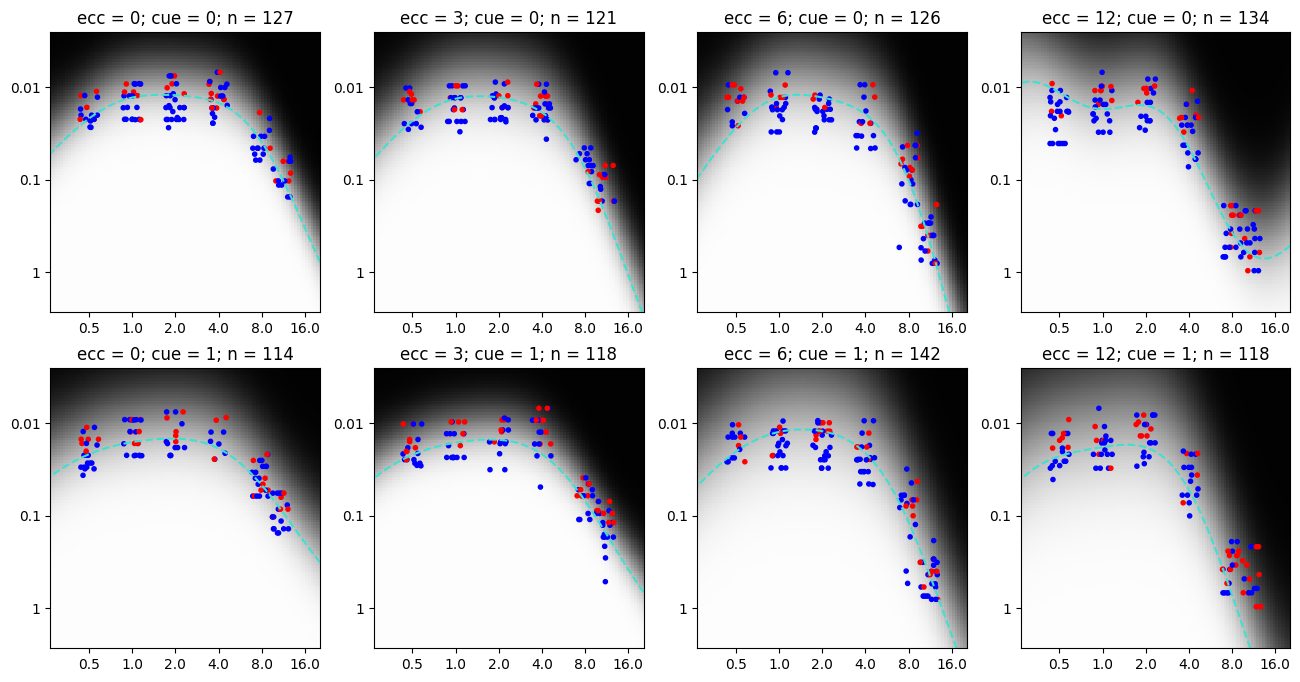

In [55]:
x_min, x_max, y_min, y_max = -0.2, 1.2, -0.2, 1.2
lamb = 0.02
gamma = 0.02

grid, xx, yy = create_evaluation_grid(x_min, x_max, y_min, y_max, 100, 100)
grid = torch.from_numpy(grid).float()

fig, axs = plt.subplots( 2, 4, figsize = (16, 8))

curve_idx = 0
for cue in range(CUES):
     for ecc in eccs:
          print(curve_idx)
          model.eval()
          likelihood.eval()
          grid_indices = torch.LongTensor(torch.full((grid.shape[0],), dtype=torch.long, fill_value=curve_idx))

          with torch.no_grad():
               # Get classification predictions
               observed_pred = likelihood(model(grid, task_indices = grid_indices))
               predicted_values = observed_pred.mean.numpy()
               
          Z = predicted_values
          zz = Z.reshape(xx.shape)
          
          
          plt.subplot(2, 4, curve_idx+1)
          plt.pcolormesh(xx, yy, zz, cmap='gist_gray', vmin=0, vmax=1)
          task_data = sampled_data[where(task_indices_sampled==curve_idx)[0]]
          colors = []
          for i in range(task_data.shape[0]):
               if task_data[i, 2] == 0:
                    colors.append('red')
               else:
                    colors.append('blue')
          jitter = np.random.uniform(-0.05,0.05,len(task_data[:,0]))
          
          plt.scatter(task_data[:, 0]+jitter, task_data[:, 1], color = colors, marker='.')
          
          level = (1 - lamb + gamma) *0.75
          plt.contour(xx, yy, zz, levels=[level], colors = 'turquoise', linestyles='dashed', dashes=(8, 8), linewidth=2)
          
          plt.ylim(y_min, y_max)
          plt.xlim(x_min, x_max)  
          
          yticks_labels = np.array([1, 0.1, 0.01])
          yticks_values = logContrast().forward(yticks_labels) / (maxCS - minCS)
          yticks_labels = ['1', 0.1, 0.01]
          xticks_labels = np.array([0.5, 1, 2, 4, 8, 16])
          xticks_values = logFreq().forward(xticks_labels) / (maxSF - minSF)
          plt.xticks(xticks_values, xticks_labels)
          plt.yticks(yticks_values, yticks_labels)
          
          title = 'ecc = '+ str(ecc) + '; cue = ' + str(cue) + '; n = ' + str(len(colors))
          plt.title(title)
          
          curve_idx += 1

fig_title = 'Conjoint.jpg'
plt.savefig(fig_title)
     

Training progress:   0%|                                                   | 0/2000 [00:00<?, ?it/s]

Training progress: 100%|███████████████████████████████████████| 2000/2000 [00:11<00:00, 181.46it/s]
/var/folders/r9/tppl2kvj6xj_mggpcv0yctjm0000gn/T/ipykernel_56345/2339040033.py:49: UserWarning: The following kwargs were not used by contour: 'dashes', 'linewidth'
  plt.contour(xx, yy, zz, levels=[level], colors = 'turquoise', linestyles='dashed', dashes=(8, 8), linewidth=2)
Training progress: 100%|███████████████████████████████████████| 2000/2000 [00:10<00:00, 190.22it/s]


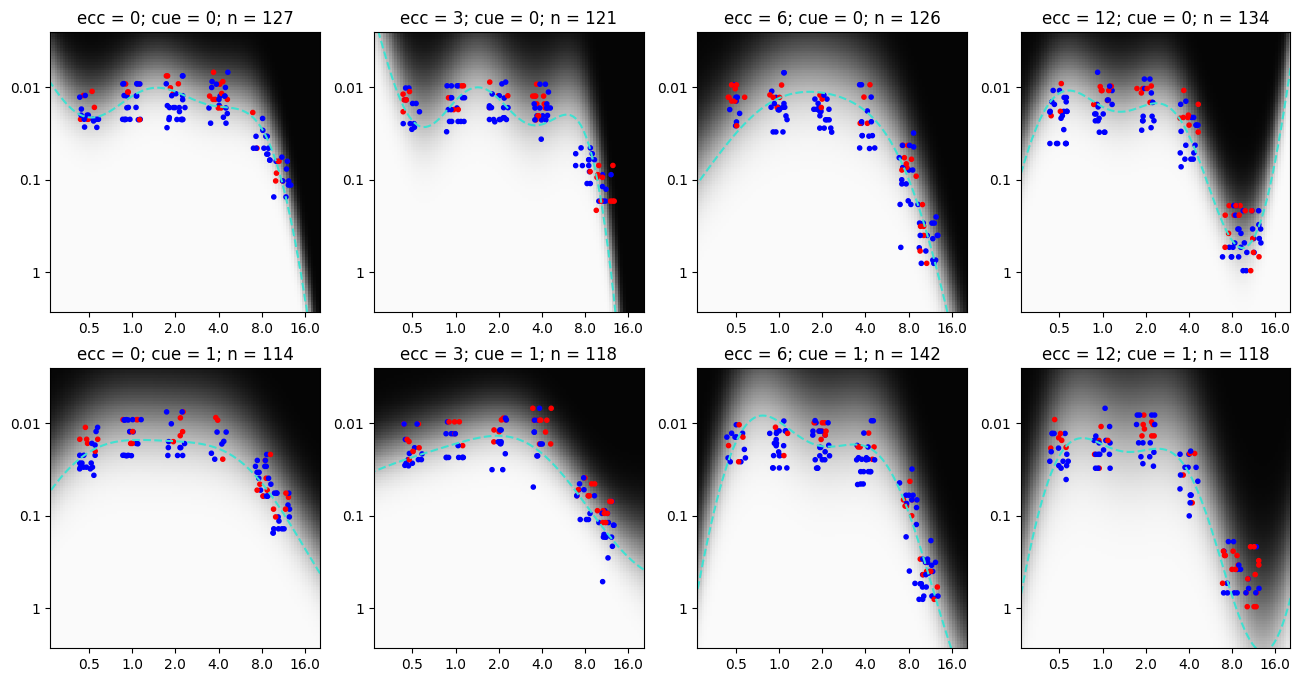

In [56]:
# disjoint figures
x_min, x_max, y_min, y_max = -0.2, 1.2, -0.2, 1.2
lamb = 0.02
gamma = 0.02

grid, xx, yy = create_evaluation_grid(x_min, x_max, y_min, y_max, 100, 100)
grid = torch.from_numpy(grid).float()

fig, axs = plt.subplots( 2, 4, figsize = (16, 8))

curve_idx = 0
for cue in range(CUES):
   for ecc in eccs:
        
      # get data
      task_data = sampled_data[where(task_indices_sampled==curve_idx)[0]]
      Xt, yt, X, y = prepare_data(task_data, raw=False, neg_labels=False)
        
      # plot the data to check
      # plt.scatter(Xt[y==0, 0], Xt[y==0, 1], color = 'red')
      # plt.scatter(Xt[y==1, 0], Xt[y==1, 1], color = 'blue')
        
      # 
      # Train GP 
      gamma = 0.02
      lamb = 0.02
      mean_module = ConstantMean()
      gp_model = GPClassificationModel(Xt, mean_module)
      likelihood = CustomBernoulliLikelihood(gamma, lamb)
      train_gp_classification_model(gp_model, likelihood, Xt, yt, beta = 0.005)
      
      # evaluate
      Z = evaluate_posterior_mean(gp_model, likelihood, grid)
      zz = Z.reshape(xx.shape)
      
      plt.subplot(2, 4, curve_idx+1)
      plt.pcolormesh(xx, yy, zz, cmap='gist_gray', vmin=0, vmax=1)
      task_data = sampled_data[where(task_indices_sampled==curve_idx)[0]]
      colors = []
      for i in range(task_data.shape[0]):
         if task_data[i, 2] == 0:
               colors.append('red')
         else:
               colors.append('blue')
      jitter = np.random.uniform(-0.05,0.05,len(task_data[:,0]))
      plt.scatter(task_data[:, 0]+jitter, task_data[:, 1], color = colors, marker='.')
          
      level = (1 - lamb + gamma) *0.75
      plt.contour(xx, yy, zz, levels=[level], colors = 'turquoise', linestyles='dashed', dashes=(8, 8), linewidth=2)
          
      plt.ylim(y_min, y_max)
      plt.xlim(x_min, x_max)  
          
      yticks_labels = np.array([1, 0.1, 0.01])
      yticks_values = logContrast().forward(yticks_labels) / (maxCS - minCS)
      yticks_labels = ['1', 0.1, 0.01]
      xticks_labels = np.array([0.5, 1, 2, 4, 8, 16])
      xticks_values = logFreq().forward(xticks_labels) / (maxSF - minSF)
      plt.xticks(xticks_values, xticks_labels)
      plt.yticks(yticks_values, yticks_labels)
          
      title = 'ecc = '+ str(ecc) + '; cue = ' + str(cue) + '; n = ' + str(len(colors))
      plt.title(title)
          
      
      curve_idx += 1
     
fig_title = 'Disjoint.jpg'
plt.savefig(fig_title)


In [57]:
print(xticks_labels)
print(xticks_values)
print(yticks_labels)
print(yticks_values)

[ 0.5  1.   2.   4.   8.  16. ]
[0.         0.22424382 0.44848765 0.67273147 0.8969753  1.12121912]
['1', 0.1, 0.01]
[-0.          0.46317864  0.92635729]


In [58]:
import numpy as np
import PIL
from PIL import Image

list_im = ['Conjoint.jpg', 'Disjoint.jpg']
imgs    = [ Image.open(i) for i in list_im ]
# pick the image which is the smallest, and resize the others to match it (can be arbitrary image shape here)
min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]

# for a vertical stacking it is simple: use vstack
imgs_comb = np.vstack([i.resize(min_shape) for i in imgs])
imgs_comb = Image.fromarray( imgs_comb)
imgs_comb.save( 'conjoint_vs_disjoint.jpg' )